In [1]:
import math
import numpy as np
import pandas as pd
import sys
import re
from functions import *
from mining_functions import *
from collections import Counter
from matplotlib.backends.backend_pdf import PdfPages
np.set_printoptions(precision=2)
pd.set_option('precision', 2)
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
PATH = '/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
def get_path(path = PATH):
    if os.name == 'posix':
        return os.environ['HOME']+path #'/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
    elif os.name == 'nt':
        return os.environ['USERPROFILE']+ path.replace('/','\\') #'\\Google Drive\Jonathan Sarah Ido folder\data\CCK\\'
    else:
        raise Exception('OS not recongnized. I\'m confused.')
gitpath = '/Documents/git/Phet-log-analyzer/cck/raw_data_parsing_check/'
df = pd.read_csv(get_path(path = gitpath) + 'phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
# dfx = pd.read_csv('C:\Users\Sarah\Documents\git\Phet-log-analyzer\cck\\raw_data_parsing_check\phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
df["student"] = df["student"].astype('category')
df["Family"]=df["Family"].str.capitalize()
df["Family_tool"]=df["Family_tool"].str.capitalize()
df["Family_default"]=df["Family_default"].str.capitalize()
df["Family_both"]=df["Family_both"].str.capitalize()

df_scores = pd.read_csv(data_path + 'MATCHING_phet_cck_user_data_anonymized.txt')
df_scores["student"] = df_scores["student"].astype('category')

### Functions used to calculate information gain, plot use, etc...

In [3]:
def add_text(attribute,family_category,N, shortest_seq_length, longest_seq_length,B):
    text = """Showing sequences for students split by {0}, using the categories {1}.
            Removed sequences used by less than {2}.
            Found sequences of lenght {3} to {4}.
            Using {5} time bins""".format(attribute,family_category,N, shortest_seq_length, longest_seq_length,B)
    fig = plt.figure(figsize=(10, 4))
    ax = plt.gca()
    ax.text(0.5,0.5,text,
        horizontalalignment='center',
        verticalalignment='center',
        fontsize = 15)
    plt.axis('off')
    return fig

In [4]:
def rank_sequences(sequence_counts,B,axesnum=None):
    ranks = []
    for seq,counts in sequence_counts.iteritems():
#         if np.sum(counts)>0:
        ranks.append((seq,calc_infogain(counts,B,axesnum)))
    return sorted(ranks, key=lambda tup: tup[1])

def get_top_seqs(ranks,N):
    return ranks[-N:]

### First we get the raw count of unique students using a sequence per time bin

In [5]:
print list(df_scores.columns.values)

['Wave', 'scaffolding', 'how many PhETs in the past?', 'how comfortable with phets?', 'p100', 'used this circuit sim before?', 'COMPLETEDNESS', 'PRIORKNOWLEDGE', 'COMPLEXITY', 'DIAGRAMS', 'NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER', 'pre', 'post t1', 'post t2', 'post identical to pre', 'z post identical to pre', 'z pre', 'z post t1', 'z post t2', 'T0_PoCC', 'T1_PoCC', 'T2_PoCC', 'Avg_Mast_Or', 'Perceived Value ', 'Clustergroups', 'fourgroups', 'student', 'Anon Student Id']


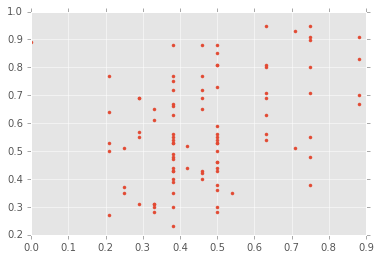

In [7]:
plt.plot(df_scores['pre'],df_scores['post t2'],'.')
# print stats.spearmanr(df_scores['z pre'],df_scores['z post t1']

SpearmanrResult(correlation=0.57518005403797434, pvalue=8.8276648284498895e-10)


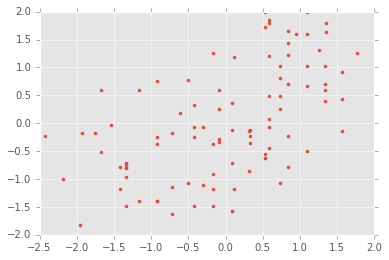

In [8]:
plt.plot(df_scores['z post t1'],df_scores['z post t2'],'.')
from scipy import stats
print stats.spearmanr(df_scores['z post t1'],df_scores['z post t2'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000E5DA400>]], dtype=object)

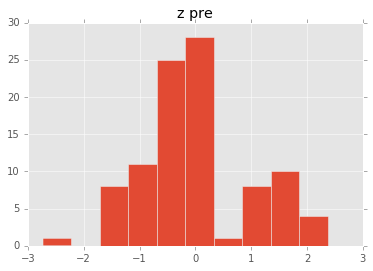

In [28]:
df_scores.hist(column='z pre')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000B8512B0>]], dtype=object)

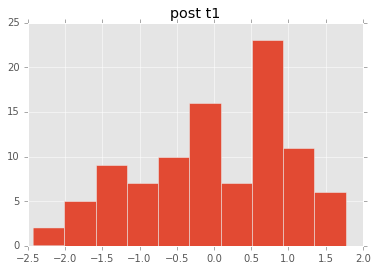

In [10]:
df_scores.hist(column='post t1')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000B9DC5F8>]], dtype=object)

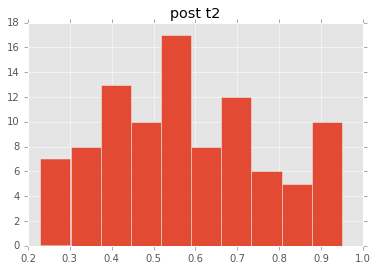

In [11]:
df_scores.hist(column='post t2')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000B6CCDA0>]], dtype=object)

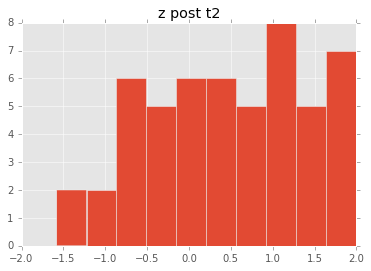

In [12]:
def label_learning (median,row,column):
    if row[column] >= median: return 'high'
    else: return 'low'
    
median_learning1 = np.median(df_scores['z post t1'])
df_scores['split_post_t1'] = df_scores.apply (lambda row: label_learning (median_learning1,row,"z post t1"),axis=1)
df_scores[df_scores['split_post_t1']=='high'].hist(column='z post t2')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000BB5CB00>]], dtype=object)

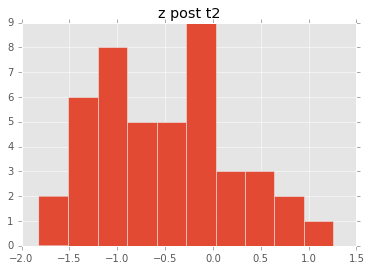

In [13]:
df_scores[df_scores['split_post_t1']=='low'].hist(column='z post t2')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000BB329E8>]], dtype=object)

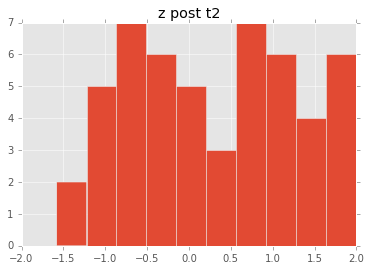

In [14]:
median_learning1 = np.median(df_scores['z pre'])
df_scores['split_pre'] = df_scores.apply (lambda row: label_learning (median_learning1,row,"z pre"),axis=1)
df_scores[df_scores['split_pre']=='high'].hist(column='z post t2')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000E243860>]], dtype=object)

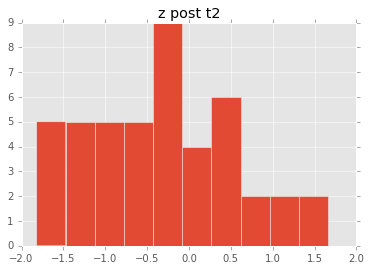

In [15]:
df_scores[df_scores['split_pre']=='low'].hist(column='z post t2')

In [34]:
median_learning1 = 0.2
df_scores['split pre'] = df_scores.apply (lambda row: label_learning (median_learning1,row,"z pre"),axis=1)
median_learning1 = np.median(df_scores['z post t2'])
df_scores['split post t2'] = df_scores.apply (lambda row: label_learning (median_learning1,row,"z post t2"),axis=1)

In [35]:
for x in ['high','low']:
    for y in ['high','low']:
        print x,y, len(set(df_scores[(df_scores['split pre']==x)&(df_scores['split post t2']==y)]['student']))
    

high high 18
high low 5
low high 31
low low 42


In [36]:
l = list(df_scores['pre'])
l.sort()
print l

[0.0, 0.20999999999999999, 0.20999999999999999, 0.20999999999999999, 0.20999999999999999, 0.20999999999999999, 0.25, 0.25, 0.25, 0.28999999999999998, 0.28999999999999998, 0.28999999999999998, 0.28999999999999998, 0.28999999999999998, 0.33000000000000002, 0.33000000000000002, 0.33000000000000002, 0.33000000000000002, 0.33000000000000002, 0.33000000000000002, 0.38, 0.38, 0.38, 0.38, 0.38, 0.38, 0.38, 0.38, 0.38, 0.38, 0.38, 0.38, 0.38, 0.38, 0.38, 0.38, 0.38, 0.38, 0.38, 0.38, 0.38, 0.38, 0.38, 0.41999999999999998, 0.41999999999999998, 0.46000000000000002, 0.46000000000000002, 0.46000000000000002, 0.46000000000000002, 0.46000000000000002, 0.46000000000000002, 0.46000000000000002, 0.46000000000000002, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.54000000000000004, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.70999999999999996, 0.70999999999999996, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.88, 0.88, 0.88, 0.88]


In [ ]:
a = set(get_students('learning2','high'))
b = set(get_students('used this circuit sim before?',1))
c = set(get_students('learning2','low'))
print len(a), len(b), len(a.intersection(b)), len(c.intersection(b))

In [ ]:
students = get_students()
CUT_OFF_SEQ_USE = 0.2 #we keep only sequences used once by at least 10% of students
N = int(CUT_OFF_SEQ_USE*len(students))
shortest_seq_length = 3
longest_seq_length = 12
B = 4  #number of bins

### PARAMETERS
attributes = [('used this circuit sim before?',1,0),
              ('scaffolding','scaff', 'not'),
              ('incoming_knowledge','high', 'low'),
              ('incoming_attitude','high', 'low'),
             ('learning2','high', 'low')]
# attributes = [('learning2','high', 'low')]

family_categories = ["Family","Family_tool","Family_default"]
# family_categories = ["Family"]

# sequence_counts = get_sequence_use_by_timebin(df,students,family_category,B,attribute,level1,level2,shortest_seq_length,longest_seq_length,N)
# for k,v in sequence_counts.iteritems():
#     print k,v, np.sum(v)

### We can calculate the information gain of each sequence by time bin

In [ ]:
parse_axis = {0:'time',1:'group',None:'time and group'}

pdf = PdfPages('infogain_results.pdf')

for attribute,level1,level2 in attributes:
    for family_category in family_categories:
        print "For attribute {0}, categories {1}".format(attribute,family_category)
        pdf.savefig(add_text(attribute,family_category,N, shortest_seq_length, longest_seq_length,B))
        sequence_counts = get_sequence_use_by_timebin(df,students,family_category,B,attribute,level1,level2,shortest_seq_length,longest_seq_length,N)
        ylabels = [level1,level2]
        for axis in [0,1,None]:
            tops = get_top_seqs(rank_sequences(sequence_counts,B,axis),3)
            for seq,infogain in tops:
                title = '{0}: infogain {1} by {2}'.format(seq,round(infogain,3),parse_axis[axis])
                plot = plot_heat_map(sequence_counts[seq],title, ylabels)
                pdf.savefig( plot )
                plot.clf()
pdf.close()

In [ ]:
plot_heat_map(sequence_counts[seq],title, ylabels)